# Legal Dataset Stats

## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import dgl
import torch as th
import importlib
import pickle

import sys,os
sys.path.insert(0, os.path.abspath('..'))
from src import data, util, graph_models, text_processing
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

/root/envs/missing_link/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
importlib.reload(data)

lio_ref_fn = 'data/lio/lio_ref.pkl'

if not os.path.exists(lio_ref_fn):
    with open(lio_ref_fn, 'wb') as fb:
        G_ = data.from_neo4j(auth=("neo4j", "admin"))
        pickle.dump(G_, fb)
    
lio_g, lio_cases, lio_laws = data.load_old_graph(lio_ref_fn)
lio_cases.rename(columns={'year':'date'}, inplace=True)
lio_laws.rename(columns={'year':'date'}, inplace=True)
lio_g.name = 'LiO338k'

lio_law_texts = lio_laws.content.fillna('').values

ref_rex = '§+ \\d+[a-z]* (Abs\\. \\d )*([A-Z]+\\S*)*( \\d)*|Abs. \\d+ ([A-Z]+\\S*)* \\d*'
lio_case_texts = lio_cases.content.fillna('').values#.str.replace(ref_rex, '[REF]', regex=True).values

In [3]:
old_ref_fn = 'data/old/old_ref.pkl'

if not os.path.exists(old_ref_fn):
    with open(old_ref_fn, 'wb') as fb:
        G_ = data.from_neo4j()
        pickle.dump(G_, fb)
    
old_g, old_cases, old_laws = data.load_old_graph(old_ref_fn)
old_g.name = 'OLD201k'

old_law_texts = old_laws.content.fillna('').values

ref_rex = '§+ \\d+[a-z]* (Abs\\. \\d )*([A-Z]+\\S*)*( \\d)*|Abs. \\d+ ([A-Z]+\\S*)* \\d*'
old_case_texts = old_cases.content.fillna('').str.replace(ref_rex, '[REF]', regex=True).values

In [13]:
graphs = (old_g, lio_g)

## Graph Composition

In [27]:
for g in graphs:
    print(g.name)
    print('\t', g)
    print('\t', g.ndata.keys())
    print('\n')

OLD201k
	 Graph(num_nodes={'Case': 201823, 'Law': 50814},
      num_edges={('Case', 'CC', 'Case'): 90189, ('Case', 'CL', 'Law'): 971625},
      metagraph=[('Case', 'Case', 'CC'), ('Case', 'Law', 'CL')])
	 dict_keys(['case_date', 'case_type', 'case_court_country', 'case_court_code', 'case_court_city', 'case_court_name', 'case_court_levelofappeal', 'case_court_jurisdicton', 'case_court_description', 'case_court_state', 'case_court_type', 'case_court_courtid', 'law_code', 'law_section', 'law_booktitle'])


LiO338k
	 Graph(num_nodes={'Case': 338360, 'Law': 10402},
      num_edges={('Case', 'CC', 'Case'): 236458, ('Case', 'CL', 'Law'): 244159, ('Law', 'LC', 'Case'): 50, ('Law', 'LL', 'Law'): 67857},
      metagraph=[('Case', 'Case', 'CC'), ('Case', 'Law', 'CL'), ('Law', 'Case', 'LC'), ('Law', 'Law', 'LL')])
	 dict_keys(['case_year', 'case_court', 'case_court_code', 'case_court_name', 'law_year', 'law_type'])




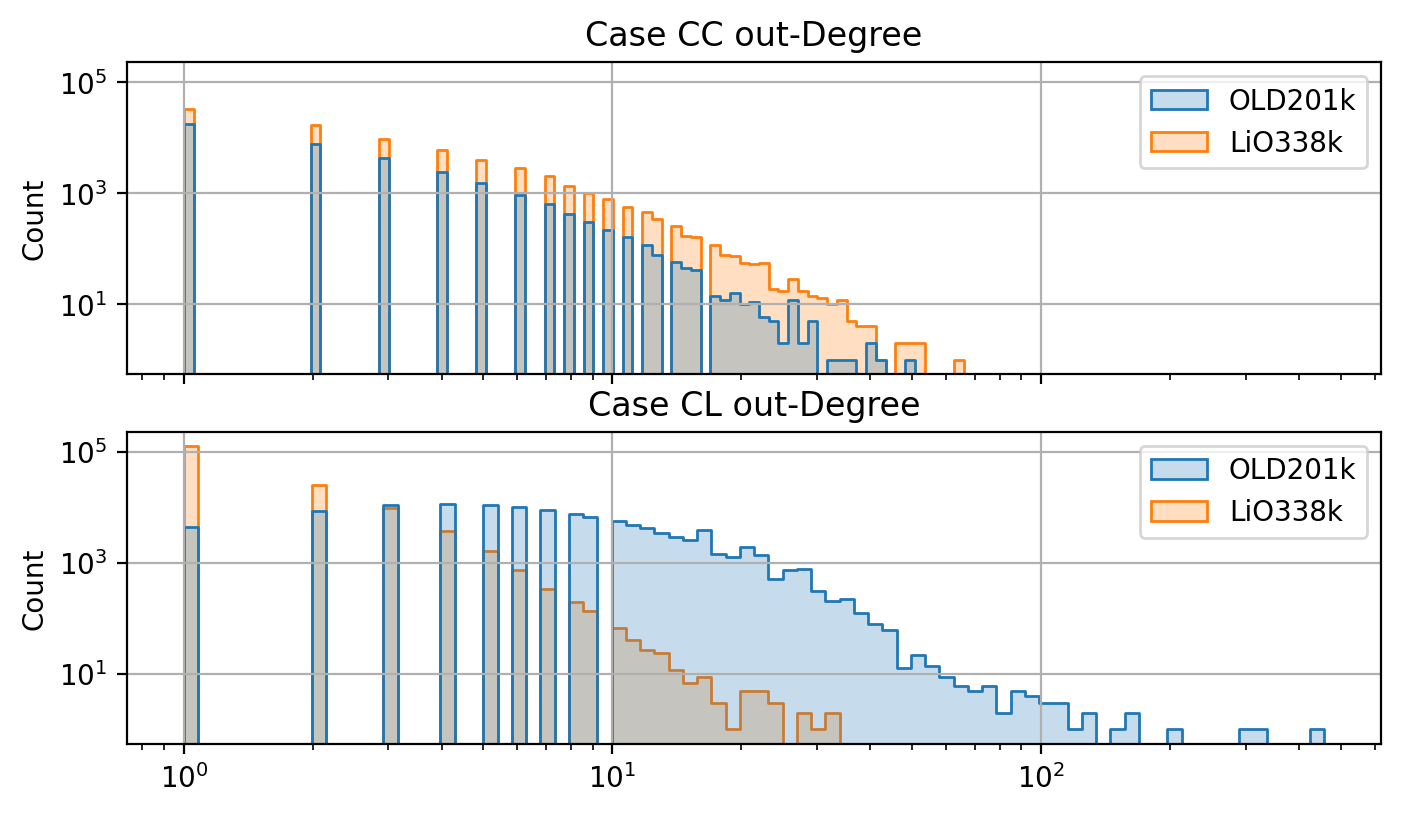

In [21]:
etypes = ('CC', 'CL')

fig, axes = plt.subplots(len(etypes), figsize=(7,4), dpi=200, sharex=True, sharey=True)
fig.tight_layout()

for ax, etype in zip(axes, etypes):
    nt1, _, nt2 = graphs[0].to_canonical_etype(etype)
    in_degs = np.hstack([g.out_degrees(etype=etype) for g in graphs])
    g_names = np.hstack([[g.name]*g.num_nodes(nt1) for g in graphs])
    sns.histplot(x=in_degs, log_scale=True, bins=80, ax=ax, hue=g_names, element="step")
    ax.semilogy(), ax.grid()
    ax.set_title(nt1 + ' ' + etype + ' out-Degree')

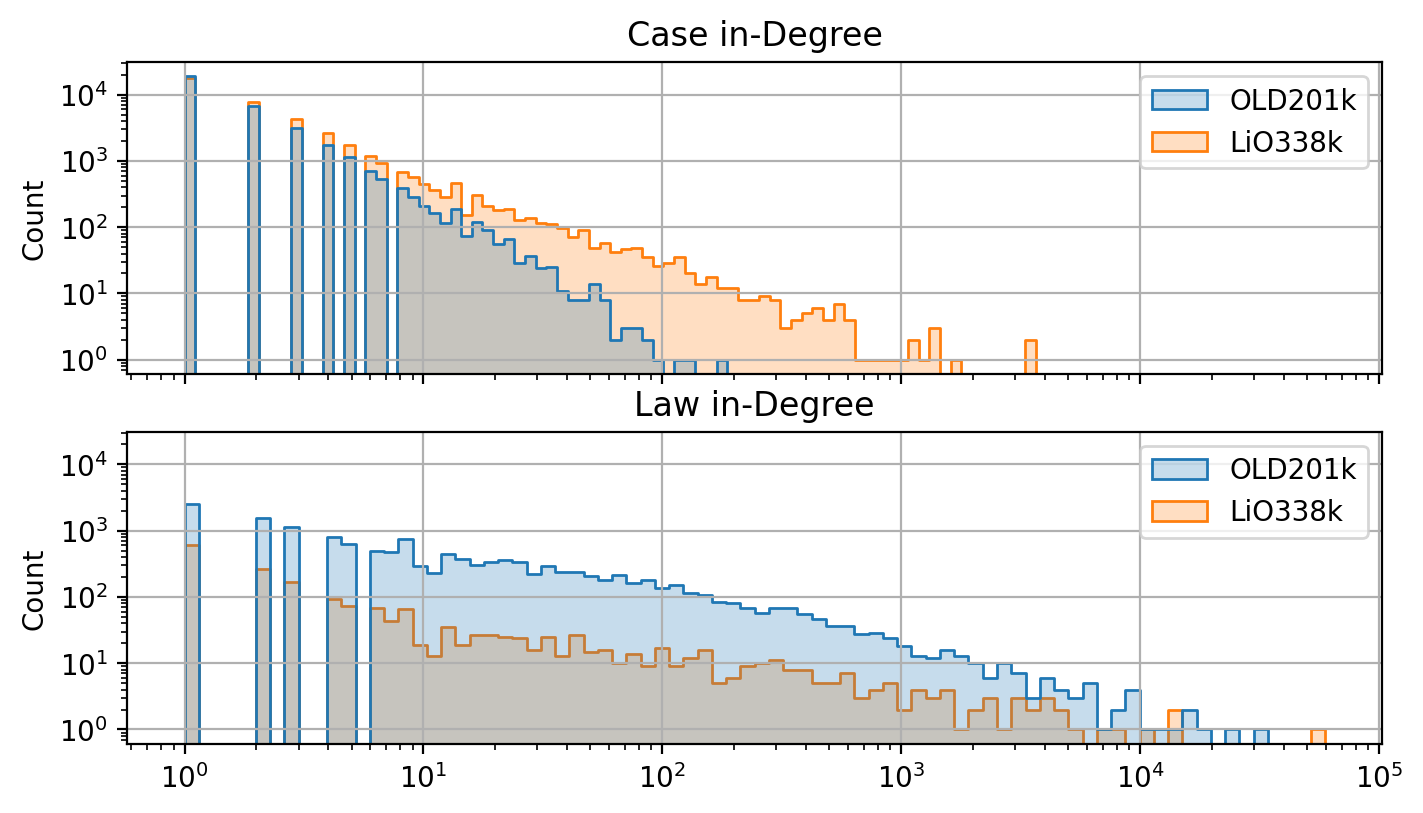

In [20]:
etypes = ('CC', 'CL')

fig, axes = plt.subplots(len(etypes), figsize=(7,4), dpi=200, sharex=True, sharey=True)
fig.tight_layout()

for ax, etype in zip(axes, etypes):
    nt1, _, nt2 = graphs[0].to_canonical_etype(etype)
    in_degs = np.hstack([g.in_degrees(etype=etype) for g in graphs])
    g_names = np.hstack([[g.name]*g.num_nodes(nt2) for g in graphs])
    sns.histplot(x=in_degs, log_scale=True, bins=80, ax=ax, hue=g_names, element="step")
    ax.semilogy(), ax.grid()
    ax.set_title(nt2 + ' in-Degree')

## Date Distributions

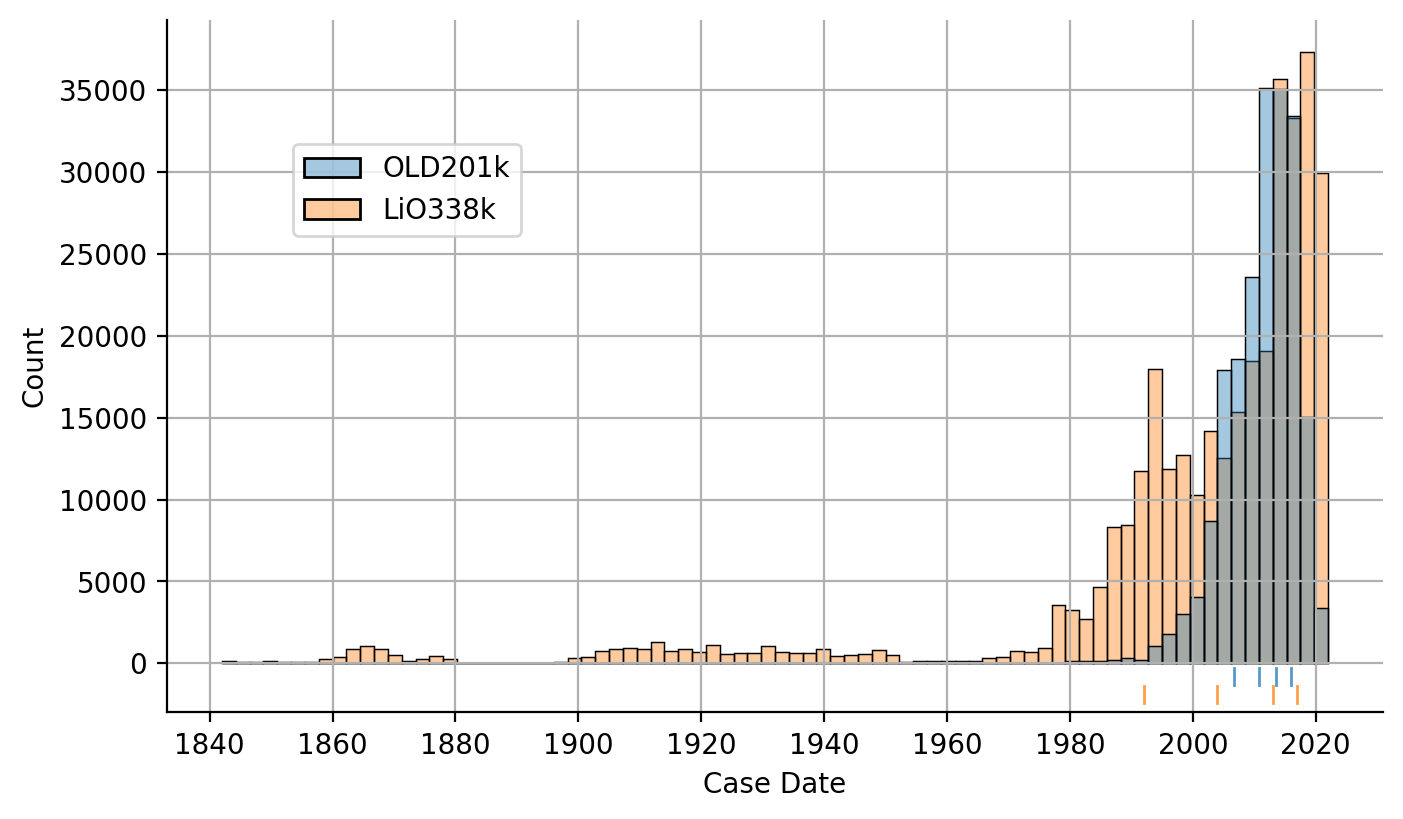

In [194]:
def date_splits(node_dates: pd.Series, cutoff: float):
    cutoff = cutoff * len(node_dates)
    num_nodes = pd.Series(node_dates).value_counts().sort_index().cumsum()
    return num_nodes.index[np.where(num_nodes >= cutoff)[0][0]]

lio_dates, old_dates = pd.to_datetime(lio_cases.date), pd.to_datetime(old_cases.date)
dates = np.hstack([old_dates, lio_dates])
dataset_names = ['OLD201k'] * len(old_cases) + ['LiO338k'] * len(lio_cases)

plt.rcParams.update({"figure.dpi": 200})
ax = sns.displot(x=dates, kde=False, height=4, aspect=1.8, hue=dataset_names, bins=80, alpha=.4)
plt.grid(), plt.xlabel('Case Date')
sns.move_legend(ax, "center",  bbox_to_anchor=(.25, .75), frameon=True)


x_val = -300
for ind, dates in enumerate((old_dates, lio_dates)):
    for c in (.2,.4,.6,.8):
        date = date_splits(dates, c)
        plt.plot([date, date], [x_val, x_val-1000], linestyle='-', c=plt.cm.tab10(ind), alpha=.75, linewidth=1)
    x_val -= 1100
    
plt.ylim(-3000, None);

## Document Length

In [52]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-de')

In [53]:
law_text_set = [old_law_texts, lio_law_texts]
case_text_set = [old_case_texts, lio_case_texts]
dataset_names = ['OLD201k', 'LiO338k']

length_df = []

for laws, cases, dataset_name in zip(law_text_set, case_text_set, dataset_names):
    df = []
    for docs, doc_name in zip([laws, cases], ['Law', 'Case']):
        lengths = [len(t) for t in tokenizer(list(docs))['input_ids']]
        df.append(pd.DataFrame({'length': lengths, 'type': doc_name}))
    length_df.append(pd.concat(df))
    length_df[-1]['dataset'] = dataset_name
    
length_df = pd.concat(length_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


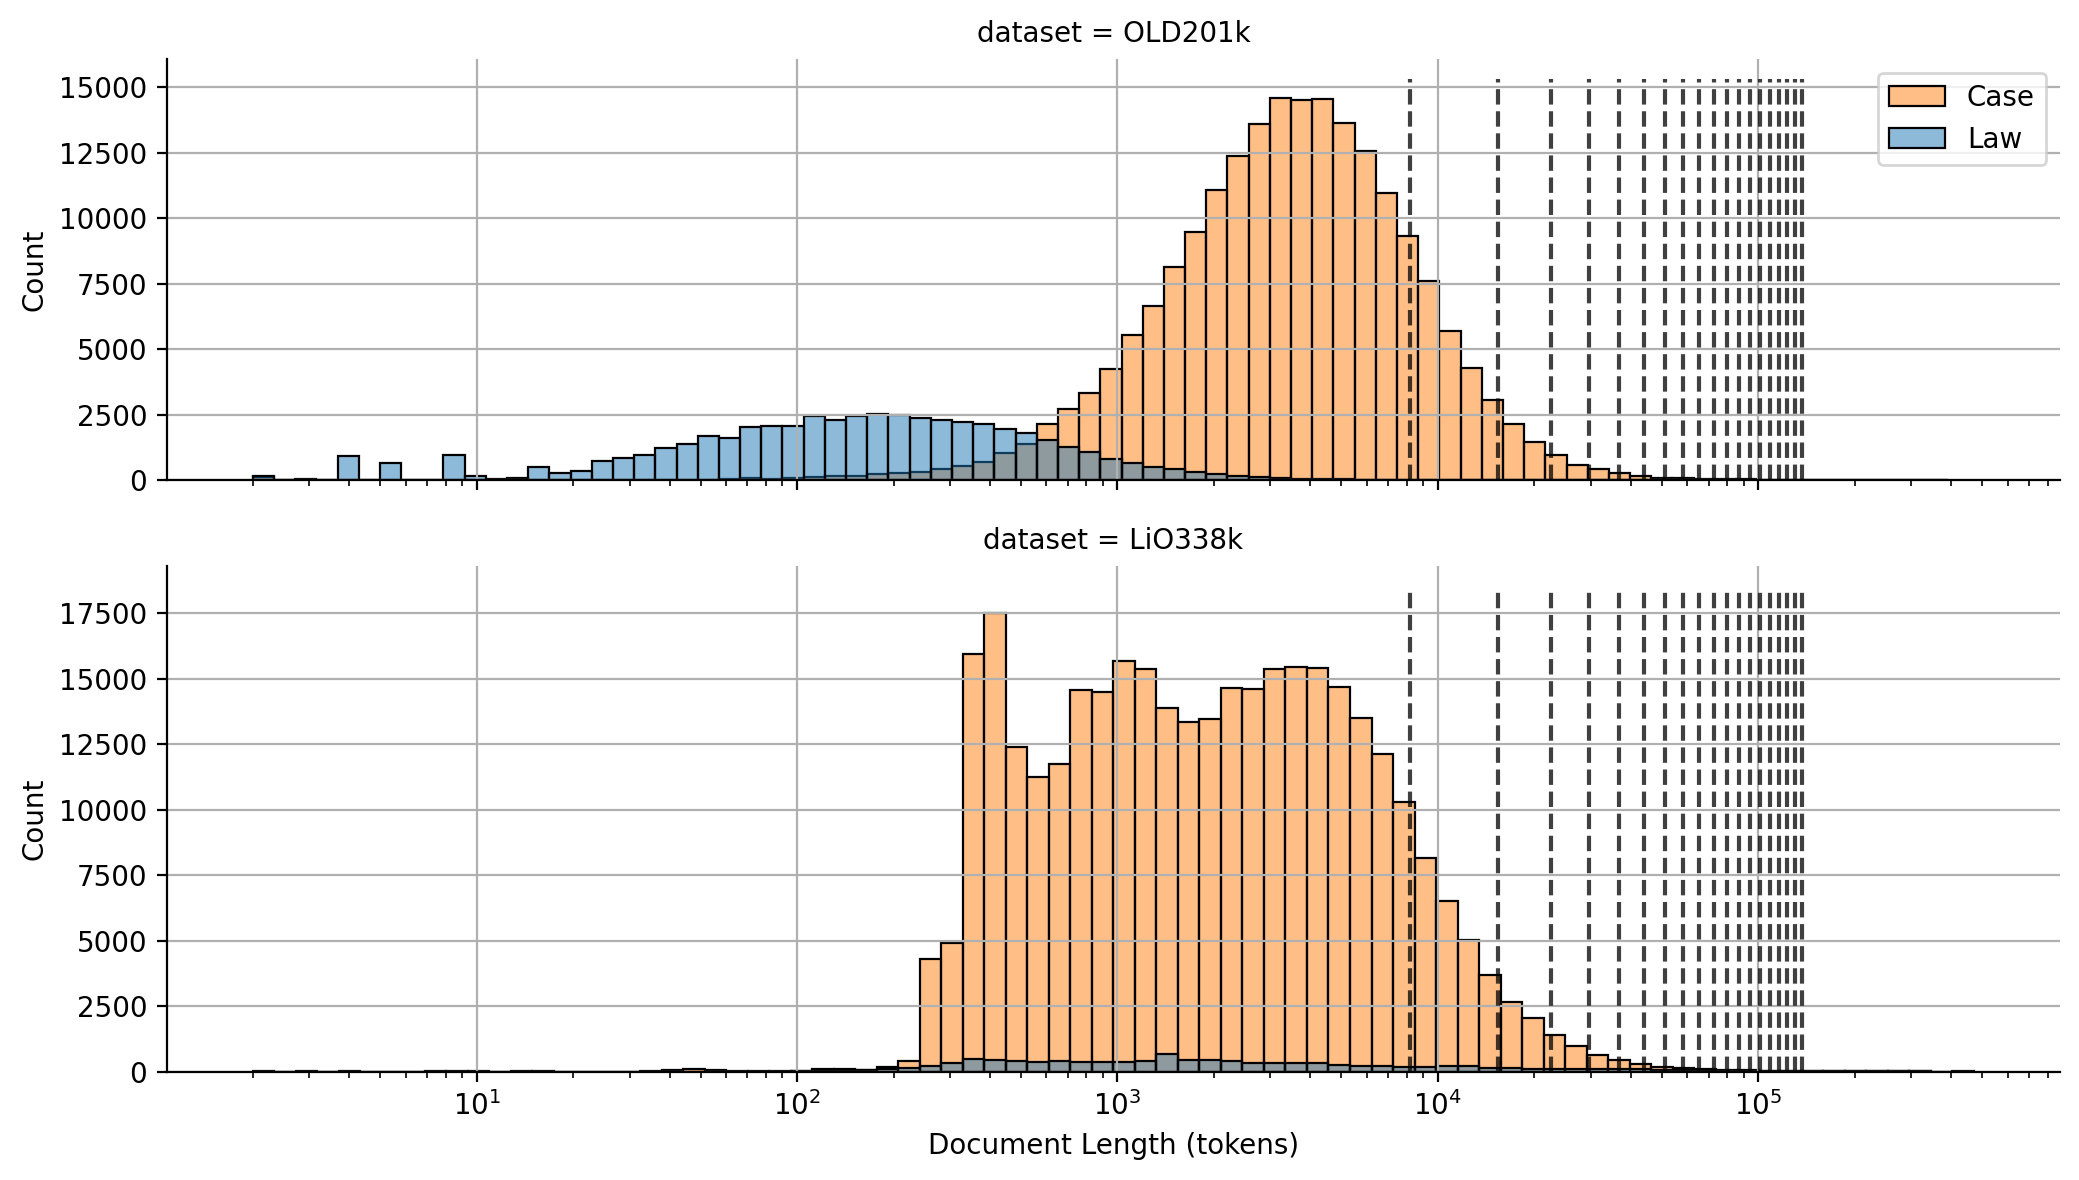

In [79]:
g = sns.FacetGrid(length_df, row='dataset', aspect=3.5, height=3, sharey=False)
g.map_dataframe(sns.histplot, x="length", bins=80, hue = 'type', log_scale=True)

ylims = np.array([np.diff(ax[0].get_ylim())[0] for ax in g.axes])
height_ratios = ylims / ylims.max()
plt.close()
    
g = sns.FacetGrid(length_df, row='dataset', aspect=3.5, height=3, 
                  gridspec_kws=dict(height_ratios=height_ratios), sharey=False)
g.map_dataframe(sns.histplot, x="length", bins=80, hue = 'type', log_scale=True)
g.axes.ravel()[0].legend(labels=sorted(length_df.type.unique()))

for ax in g.axes.ravel():
    ax.grid()
    y_vals = ax.get_ylim()
    for n in range(1,20):
        ctx = 8192 * n - (n-1)*1024
        ax.plot([ctx, ctx], y_vals, c='k', alpha=.75, linestyle='--')
    
plt.xlabel('Document Length (tokens)');

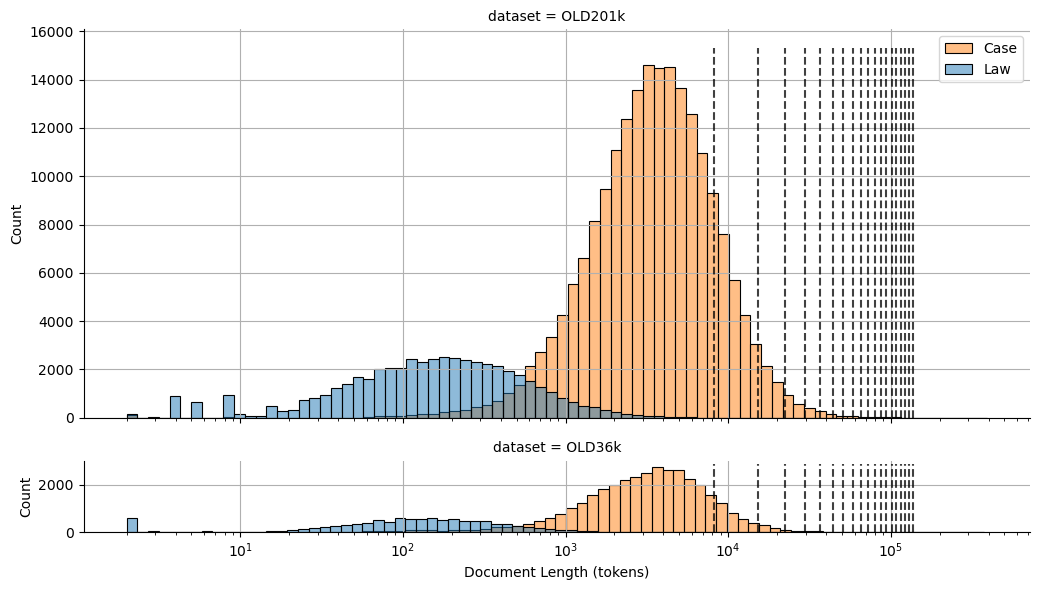

In [7]:
g = sns.FacetGrid(length_df, row='dataset', sharey=False)
g.map_dataframe(sns.histplot, x="length", bins=80, hue = 'type')

ylims = np.array([np.diff(ax[0].get_ylim())[0] for ax in g.axes])
height_ratios = ylims / ylims.max()
plt.close()
    
g = sns.FacetGrid(length_df, row='dataset', aspect=3.5, height=3, 
                  gridspec_kws=dict(height_ratios=height_ratios), sharey=False)
g.map_dataframe(sns.histplot, x="length", bins=80, hue = 'type', log_scale=True)
g.axes.ravel()[0].legend(labels=sorted(length_df.type.unique()))

for ax in g.axes.ravel():
    ax.grid()
    y_vals = ax.get_ylim()
    for n in range(1,20):
        ctx = 8192 * n - (n-1)*1024
        ax.plot([ctx, ctx], y_vals, c='k', alpha=.75, linestyle='--')
    
plt.xlabel('Document Length (tokens)');

In [334]:
length_df.groupby(['type', 'dataset']).agg(
    lambda s: [round((s <= 8192 * n - (n-1)*1024).sum() / len(s)*100, 1) for n in range(1,5)])

length
type dataset                              
Case OLD201k      [85.0, 96.6, 98.8, 99.5]
     OLD36k       [88.9, 97.8, 99.3, 99.7]
Law  OLD201k  [100.0, 100.0, 100.0, 100.0]
     OLD36k   [100.0, 100.0, 100.0, 100.0]